# Introduction to Decision Trees

Decision trees make excellent classifiers.  They are able to capture more complicated structure than linear models and a trained decision tree has an easy interpretation that matches the way humans approach many tasks.

A decision tree makes predictions by partitioning the input space, or the space that our data lives in, into regions and then assigning a label to each region. By repeatedly partitioning the space using multiple variables or splitting the same variable multiple times, decision trees can learn very complex classification rules that are hard to approximate with other models (particularly linear regression, which we explored last week).

How does the decision tree decide where to split?  And how does it know which dimension to split on first?  These decisions will be determined by the mathematical formulation of the model, and we will omit them here. If you are interested in learning more, see <a href="https://en.wikipedia.org/wiki/Decision_tree_learning">this wikipedia article</a>.  To specifically learn about how decision trees split the input space into regions, read the section titled "Metrics." If you're an algorithms person, know that most decision tree classifiers use a "greedy" algorithm to fit the best tree, and then shrink or "prune" the tree.

That said, let's take a look at using these things. We'll use the same data from last week (read more about it <a href="https://www.kaggle.com/c/mdst-flint">here</a>)

In [97]:
# We begin by importing numpy and pandas, as usual.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We'll be evaluating our models as well.
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve

In [98]:
train_df = pd.read_csv('./data/flint_train.csv')
test_df = pd.read_csv('./data/flint_test.csv')
train_df.head()

,sample_id,Lead_(ppb),parcel_id,Date_Submitted,google_add,Latitude,Longitude,Owner_Type,Land_Value,Land_Improvements_Value,...,Ward,PRECINCT,CENTRACT,CENBLOCK,SL_Type,SL_Type2,SL_Lead,Homestead,Homestead_Percent,HomeSEV
0,sample_012585,0.0,parcel_000036,2015-09-25 11:07:30,"1930 Colchester Rd, Flint, MI 48503, USA",42.994119,-83.723837,Private,20173,0,...,8,50,003600,6,1,0,0,Yes,100.0,35000
1,sample_006656,0.0,parcel_000036,2016-02-12 13:05:05,"1930 Colchester Rd, Flint, MI 48503, USA",42.994119,-83.723837,Private,20173,0,...,8,50,003600,6,1,0,0,Yes,100.0,35000
2,sample_007366,0.0,parcel_004160,2015-09-30 13:06:52,"605 Garland St, Flint, MI 48503, USA",43.020701,-83.696796,Private,15089,85227,...,5,32,002800,2,1,0,0,No,0.0,0
3,sample_014024,4.0,parcel_004160,2015-09-30 13:06:51,"605 Garland St, Flint, MI 48503, USA",43.020701,-83.696796,Private,15089,85227,...,5,32,002800,2,1,0,0,No,0.0,0
4,sample_003639,0.0,parcel_010786,2015-09-30 13:07:02,"4307 Ogema Ave, Flint, MI 48507, USA",42.984745,-83.660663,Private,7526,0,...,9,61,003500,3,1,0,0,Yes,100.0,0


Last week, we learned how to use the `get_dummies()` function to generate binary dummy indicator variables for categorical data. We'll apply that here. Notice that we combine our train and test data first to ensure that all possible categories of each variable are represented in both datasets (otherwise, our train and test data may not "line up").

In [99]:
dummy_columns = ['Owner_Type', 'Residential_Building_Style', 'USPS_Vacancy', 
                 'Building_Storeys', 'Rental', 'Use_Type', 'Prop_Class', 'Zoning', 'Future_Landuse', 'DRAFT_Zone',
                 'Housing_Condition_2012', 'Housing_Condition_2014','Hydrant_Type', 'Ward', 'PRECINCT', 'CENTRACT', 
                 'Commercial_Condition_2013','CENBLOCK', 'SL_Type', 'SL_Type2', 'SL_Lead', 'Homestead']

drop_columns = ['sample_id', 'google_add', 'parcel_id', 'Date_Submitted']

combined_df = train_df.append(test_df)

combined_df = combined_df.drop(drop_columns, axis=1)
combined_df = pd.get_dummies(combined_df, columns = dummy_columns)

train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

# The combining of the dataframes created an empty column for lead in test_df.  We drop it here.
test_df = test_df.drop('Lead_(ppb)', axis=1)

What follows should be starting to look like old news if you have been coming to the tutorials. The train-test partition should be part of your routine approach to a data science task (or you can use something similar, like cross validation).  

Split the training data into a training set and a test set.  We will use these sets to experiment and see which models are better.

In [100]:
from sklearn.model_selection import train_test_split

Ydata_r = train_df['Lead_(ppb)']
Ydata_c = train_df['Lead_(ppb)'] > 15
Xdata = train_df.drop('Lead_(ppb)', axis=1)

# We'll be starting with a regression problem, so split on Ydata_r
random_seed = 102018
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata_c, random_state = random_seed)

There are several different classifiers in sklearn that depend on decision trees.  We will start with the simplest one, a single tree classifier.  These become the building blocks of more complicated models.

We'll use our best friend, `fit()`, to fit the model. Recall that the `fit()` method always takes an `n x (p-1)` array of predictors as its first argument (X), and an `n x 1` array of labels as its second argument (Y).

In [101]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(Xtrain, Ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Next, we'll use a new function, `predict_proba()`, to predict the class probabilities on the test data. This helps us check the fit of the model to the training data.

In [102]:
yhat1 = dt.predict_proba(Xtest)

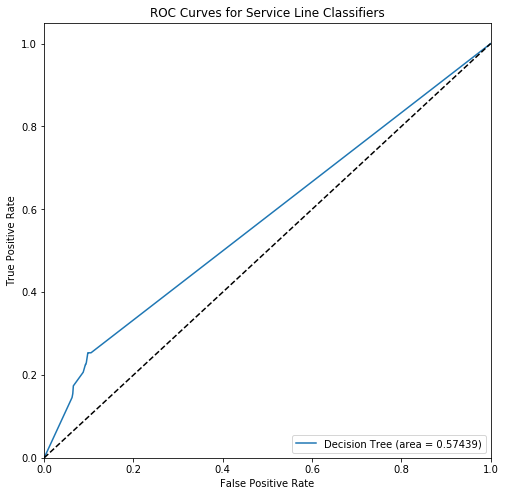

In [103]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat1[:,1])
plt.plot(fpr, tpr, label= 'Decision Tree (area = %0.5f)' % roc(Ytest, yhat1[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

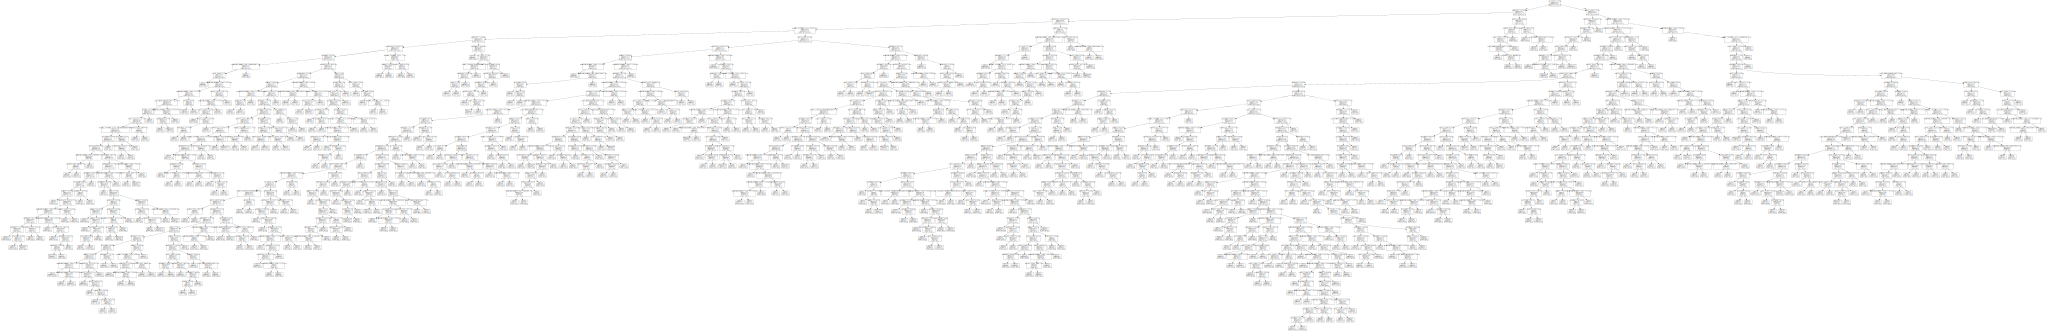

In [104]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
graph = Source( tree.export_graphviz(dt, out_file=None, feature_names=Xtrain.columns))
SVG(graph.pipe(format='svg'))

This classifier is ok, but we can do better. A common problem with decision trees is that they tend to overfit the training data (this wasn't considered a big problem for some of the early applications of decision trees, which included predicting chess endgames). This looks like it's happening here, based on the complexity of the tree, but there are more formal procedures we could look at to explore the degree of overfitting.

You could minimize the overfitting by tuning some of the model parameters  and experimenting with different algorithms for building the trees; we'll cover some of these *hyperparameter tuning* techniques in a future tutorial.

# Random Forests

Random forests were created to rectify some of the problems with traditional decision trees, but they trade off some interpretability for this performance. Random forest classifiers generally achieve excellent out-of-the-box performance on a wide variety of tasks.  They are parallelizable (which makes them computationally cheap), and the produce very good results.  They are a good go-to first classifier when you get a new data set.

Random forests are collections of decision trees.  Each split of each tree learns on a different, randomly-selected subset of the columns in the data space.  Once all the trees are learned, the model combines the predictions into a better classifer.  How????

This will help you get a little bit of intuition.  Suppose that we had 4 models that were independent of each other.  The models make a correct prediction with the following probabilities:

<pre>

|       | Probability Correct | Probability Incorrect |
|-------|---------------------|-----------------------|
|Model 1|       0.70          |         0.30          |
|Model 2|       0.65          |         0.35          |
|Model 3|       0.60          |         0.40          |
|Model 4|       0.55          |         0.45          |
|-------|---------------------|-----------------------|

</pre>

What is the probability that Model 1 makes an incorrect prediction while model 2, 3 and 4 make a correct prediction?

In [105]:
0.3*0.65*0.6*0.5, 0.7*0.35*0.4*0.45

(0.058499999999999996, 0.04409999999999999)

In [106]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1024, n_jobs=-1)
rf.fit(Xtrain, Ytrain)
yhat2 = rf.predict_proba(Xtest)

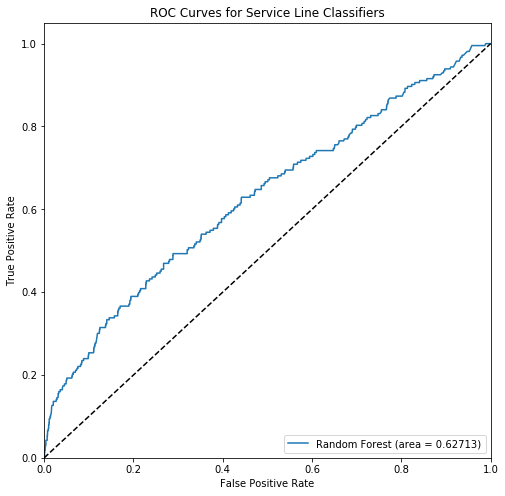

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat2[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat2[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

ExtraTreesClassifier is like a random forest, only EXTRA RANDOM!  This model is called an extremely randomized trees model.  This model acts like a random forest, except instead of training the individual decision trees the usual way by  trying to split the input space optimally it splits the input space randomly (the variables are random, *and* the decision rules are random partitions of those variables).  Hence "Extremely Random."

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=4096, n_jobs=-1)
et.fit(Xtrain, Ytrain)
yhat3 = et.predict_proba(Xtest)

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat3[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat3[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

These results are starting to look much better.

# Boosting

Another method to improve basic classification trees (or other methods) is called *boosting*. 

Boosting methods repeatedly learn a series of "weak learners" to classify the data, but at the end of each iteration, they also re-learn a set of *weights* on the training data that this learned misclassified. These weights are applied to the next iteration of training, so that the next model fits more closely to the misclassified points.

In some problems boosting can be less susceptible to the overfitting problem than other learning algorithms. The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing (e.g., their error rate is smaller than 0.5 for binary classification), the final model can be proven to converge to a strong learner.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 500, random_state=random_seed)
adaboost.fit(Xtrain, Ytrain)

Let's see how this classifier performs on the test data, compared to the other classifiers above.

In [ ]:
yhat4 = adaboost.predict_proba(Xtest)

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat4[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat4[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

If you play with the adaboost parameters, you can increase the performance of this method. In particular, the performance of adaboost generally improves monotonically as the number of boosting iterations (n_estimators) increases -- the more you increase this, generally, the better your model will perform.

## Variable Importance
Finally, let's look at variable importance. "Importance" measures how useful features are for predicting the outcome in a given model. 

Note: Importance is measured differently for different models, and these methods aren't necessarily equivalent, so importances aren't directly comparable across models. We generally use it to get a sense of which variables are most useful. Importance is particularly valuable for "black box" classifiers which don't have easily accessible/interpretable parameters.

In [ ]:
importances = adaboost.feature_importances_
imp_df = pd.DataFrame({'variable': Xtrain.columns.tolist(), 'importance': importances})
# create dataframe with top 10 by variable importance
df_top = imp_df.nlargest(10, columns = ['importance'], keep='first').sort_values(by = 'importance', ascending = True)
labs = df_top['variable']
# plot
fig = plt.figure()
df_top.plot.barh(fontsize = 12,  figsize = (8,8)).set_yticklabels(labs, rotation=0)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Variable Importance for adaBoost Classifier')
plt.show()